# Reto: Store Sales - Time Series Forecasting

Kaggle Competition: https://www.kaggle.com/competitions/store-sales-time-series-forecasting

Análisis Inicial:

Miembros del equipo:
- Josemaría Robledo A01612376
- Ricardo Andrés Cáceres Villibord A01706972
- Rodrigo Muñoz Guerrero A00572858





---



##Contexto

Los pronósticos son especialmente relevantes para las tiendas de comestibles tradicionales, que deben controlar con delicadeza la cantidad de inventario que deben comprar. Si se pronostica un poco más, los tenderos se quedarán atrapados con productos perecederos y con exceso de existencias. Si adivina un poco menos, los artículos populares se agotan rápidamente, lo que provoca pérdida de ingresos y malestar en los clientes.

Una previsión más precisa, gracias al aprendizaje automático, podría ayudar a garantizar que los minoristas complazcan a los clientes al tener la cantidad suficiente de los productos adecuados en el momento adecuado. La situación planteada abarca específicamente a las tiendas de Corporación Favorita, un gran minorista de comestibles con sede en Ecuador. En el año 2016 hubo un terremoto en Ecuador, el cual podría afectar los datos.

##Objetivo

El objetivo a conseguir con los datos, es predecir las ventas unitarias de la franquicia Favorita, para cada una de sus sucursales y por días festivos. Para posteriormente generar un modelo de predicciones que apoye a la toma de decisiones.

### Importar librerías necesarias y montar el drive

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import os
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_log_error
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.tsa.deterministic import CalendarFourier, DeterministicProcess

### Cargar Datos

Existen dos alternativas para cargar los datos, en la primera es en caso de que se ejecute el código dentro de un ambiente como Google Colab. En la segunda opción (la que se encuentra comentada) es específica para usar el cuaderno para subirlo en una competencia de Kaggle. Dependiendo del entorno de ejecución, se deberá comentar una u otra forma de carga de datos.

In [ ]:
## LOAD EN GOOGLE COLAB

from google.colab import drive
drive.mount("/content/gdrive")
%cd '/content/gdrive/Shareddrives/Reto Store Sales/Store Sales/Datasets'

df_train = pd.read_csv('train.csv',
                            usecols=['store_nbr', 'family', 'date', 'sales', 'onpromotion'],
                            dtype={
                                'store_nbr': 'category',
                                'family': 'category',
                                'sales': 'float32',
                                'onpromotion':'uint32'
                            },
                            parse_dates=['date'],
                            infer_datetime_format=True,
                        )

df_holidays = pd.read_csv('holidays_events.csv',
                              dtype={
                                  'type': 'category',
                                  'locale': 'category',
                                  'locale_name': 'category',
                                  'description': 'category',
                                  'transferred': 'bool',
                              },
                              parse_dates=['date'],
                              infer_datetime_format=True,
                          )
df_holidays = df_holidays.set_index('date').to_period('D')

df_test = pd.read_csv('test.csv',
                          dtype={
                              'store_nbr': 'category',
                              'family': 'category',
                              'onpromotion': 'uint32',
                          },
                          parse_dates=['date'],
                          infer_datetime_format=True,
                      )
df_test['date'] = df_test.date.dt.to_period('D')
df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

df_stores = pd.read_csv('stores.csv')
df_transactions = pd.read_csv('transactions.csv')
df_oil = pd.read_csv('oil.csv')


## LOAD EN KAGGLE

# comp_dir = Path('../input/store-sales-time-series-forecasting')

# holidays_events = pd.read_csv(
#                                   comp_dir / "holidays_events.csv",
#                                   dtype={
#                                       'type': 'category',
#                                       'locale': 'category',
#                                       'locale_name': 'category',
#                                       'description': 'category',
#                                       'transferred': 'bool',
#                                   },
#                                   parse_dates=['date'],
#                                   infer_datetime_format=True,
#                               )
# holidays_events = holidays_events.set_index('date').to_period('D')

# df_train = pd.read_csv(
#                             comp_dir / 'train.csv',
#                             usecols=['store_nbr', 'family', 'date', 'sales'],
#                             dtype={
#                                 'store_nbr': 'category',
#                                 'family': 'category',
#                                 'sales': 'float32',
#                             },
#                             parse_dates=['date'],
#                             infer_datetime_format=True,
#                         )
# df_train['date'] = df_train.date.dt.to_period('D')
# df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()
# average_sales = (
#     df_train
#     .groupby('date').mean()
#     .squeeze()
#     .loc['2017']
# )

# df_test = pd.read_csv(
#                           comp_dir / 'test.csv',
#                           dtype={
#                               'store_nbr': 'category',
#                               'family': 'category',
#                               'onpromotion': 'uint32',
#                           },
#                           parse_dates=['date'],
#                           infer_datetime_format=True,
#                       )
# df_test['date'] = df_test.date.dt.to_period('D')
# df_test = df_test.set_index(['store_nbr', 'family', 'date']).sort_index()

Mounted at /content/gdrive
/content/gdrive/Shareddrives/Reto Store Sales/Store Sales/Datasets


### Ver tipos de datos

In [ ]:
print("DF_TRAIN: \n")
df_train.info()

DF_TRAIN: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000888 entries, 0 to 3000887
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   date         datetime64[ns]
 1   store_nbr    category      
 2   family       category      
 3   sales        float32       
 4   onpromotion  uint32        
dtypes: category(2), datetime64[ns](1), float32(1), uint32(1)
memory usage: 51.5 MB


In [ ]:
print("DF_TEST: \n")
df_test.info()

DF_TEST: 

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 28512 entries, ('1', 'AUTOMOTIVE', Period('2017-08-16', 'D')) to ('9', 'SEAFOOD', Period('2017-08-31', 'D'))
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           28512 non-null  int64 
 1   onpromotion  28512 non-null  uint32
dtypes: int64(1), uint32(1)
memory usage: 419.3 KB


In [ ]:
print("DF_STORES: \n")
df_stores.info()

DF_STORES: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   store_nbr  54 non-null     int64 
 1   city       54 non-null     object
 2   state      54 non-null     object
 3   type       54 non-null     object
 4   cluster    54 non-null     int64 
dtypes: int64(2), object(3)
memory usage: 2.2+ KB


In [ ]:
print("DF_TRANSACTIONS: \n")
df_transactions.info()

DF_TRANSACTIONS: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83488 entries, 0 to 83487
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   date          83488 non-null  object
 1   store_nbr     83488 non-null  int64 
 2   transactions  83488 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.9+ MB


In [ ]:
print("DF_OIL: \n")
df_oil.info()

DF_OIL: 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1218 entries, 0 to 1217
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date        1218 non-null   object 
 1   dcoilwtico  1175 non-null   float64
dtypes: float64(1), object(1)
memory usage: 19.2+ KB


In [ ]:
print("DF_HOLIDAYS: \n")
df_holidays.info()

DF_HOLIDAYS: 

<class 'pandas.core.frame.DataFrame'>
PeriodIndex: 350 entries, 2012-03-02 to 2017-12-26
Freq: D
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   type         350 non-null    category
 1   locale       350 non-null    category
 2   locale_name  350 non-null    category
 3   description  350 non-null    category
 4   transferred  350 non-null    bool    
dtypes: bool(1), category(4)
memory usage: 10.4 KB


### Convertir datos de fecha a tipo `datetime` y verificar si hay valores NaN

In [ ]:
df_transactions['date'] = pd.to_datetime(df_transactions['date'])
df_oil['date'] = pd.to_datetime(df_oil['date'])

print("NaNs en TRAIN: ", df_train.isna().sum())
print("\n NaNs en TEST: ", df_test.isna().sum())
print("\n NaNs en STORES: ", df_stores.isna().sum())
print("\n NaNs en TRANSACTIONS: ",df_transactions.isna().sum())
print("\n NaNs en OIL: ",df_oil.isna().sum())
print("\n NaNs en HOLIDAYS: ",df_holidays.isna().sum())

NaNs en TRAIN:  date           0
store_nbr      0
family         0
sales          0
onpromotion    0
dtype: int64

 NaNs en TEST:  id             0
onpromotion    0
dtype: int64

 NaNs en STORES:  store_nbr    0
city         0
state        0
type         0
cluster      0
dtype: int64

 NaNs en TRANSACTIONS:  date            0
store_nbr       0
transactions    0
dtype: int64

 NaNs en OIL:  date           0
dcoilwtico    43
dtype: int64

 NaNs en HOLIDAYS:  type           0
locale         0
locale_name    0
description    0
transferred    0
dtype: int64


### Graficar las ventas por día

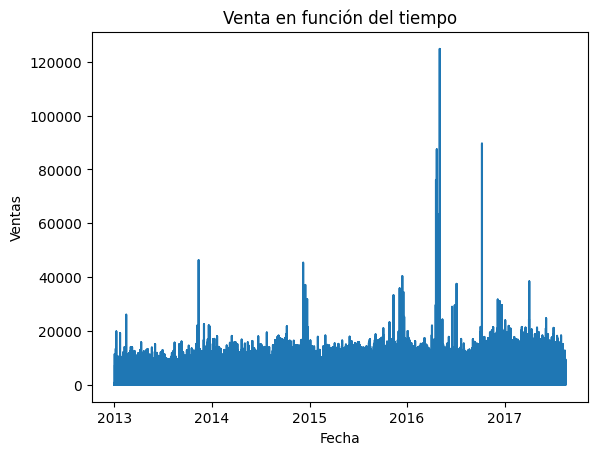

In [ ]:
plt.plot(df_train['date'], df_train.sales)
plt.title("Venta en función del tiempo")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.show()

Existen varios outliers en el año 2016, gracias al contexto dado por Kaggle, se sabe que los mayores picos son durante abril-mayo de 2016, debido al terremoto sucedido, el cual afecto durante todo un mes las ventas. Para que estos eventos extraordinarios no afecten al entrenamiento del modelo, se cortarán todos aquellas ventas que superen 60,000.

In [ ]:
max_sales_date = df_train.loc[df_train['sales'].idxmax()]['date']
print(f"El día con mas ventas es: {max_sales_date}")

El día con mas ventas es: 2016-05-02 00:00:00


Entra en el periodo de tiempo específico del terremoto, por lo cual no hay que considerarlo.

In [ ]:
df_holidays[df_holidays['description'].str.contains('Terremoto')]

,type,locale,locale_name,description,transferred
date,,,,,
2016-04-16,Event,National,Ecuador,Terremoto Manabi,False
2016-04-17,Event,National,Ecuador,Terremoto Manabi+1,False
2016-04-18,Event,National,Ecuador,Terremoto Manabi+2,False
2016-04-19,Event,National,Ecuador,Terremoto Manabi+3,False
2016-04-20,Event,National,Ecuador,Terremoto Manabi+4,False
2016-04-21,Event,National,Ecuador,Terremoto Manabi+5,False
2016-04-22,Event,National,Ecuador,Terremoto Manabi+6,False
2016-04-23,Event,National,Ecuador,Terremoto Manabi+7,False
2016-04-24,Event,National,Ecuador,Terremoto Manabi+8,False


### Promedio antes de quitar outliers


In [ ]:
print("PROMEDIO: ", df_train['sales'].mean())

PROMEDIO:  357.7758


### Eliminar un outlier y se grafican las ventas ya sin el outlier

Se eliminan los outliers de ventas asignandoles el valor promedio de todo el dataset sin los valores superiores a 60,000. Esto para tomar esos días como días promedio y que la situación del terremoto no sesgue el modelo.

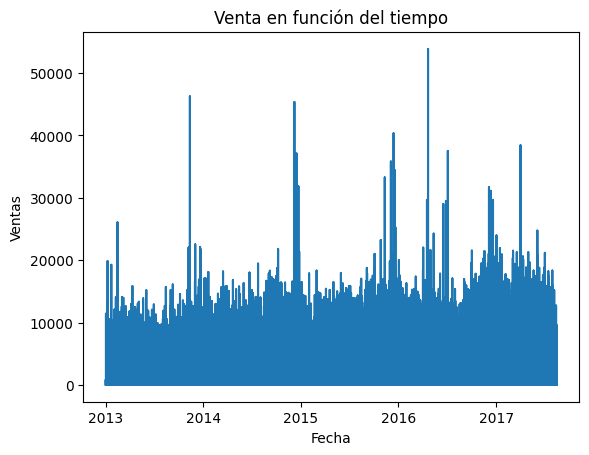

In [ ]:
df_clean = df_train[df_train['sales'] < 60000]
df_train['sales'] = df_train['sales'].apply(lambda x : df_clean['sales'].mean() if x > 60000 else x)
plt.plot(df_train['date'], df_train.sales)
plt.title("Venta en función del tiempo")
plt.xlabel("Fecha")
plt.ylabel("Ventas")
plt.show()

En el dataframe de df_train se aprecia que los picos restantes de la gráfica no se deben específicamente al terremoto, por lo que ya no los estandarizamos.

### Ventas por familia de productos

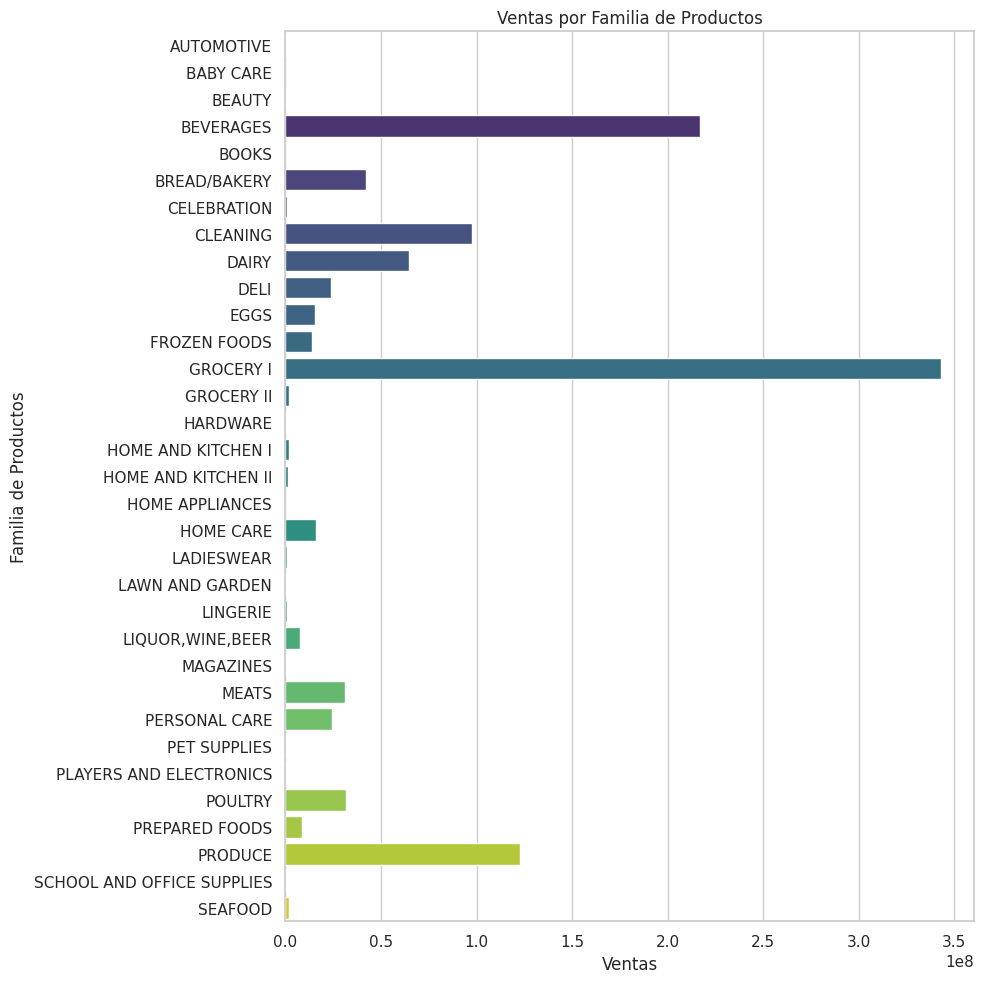

VENTAS POR FAMILIA DE PRODUCTOS: 
                         family         sales
12                   GROCERY I  3.431125e+08
3                    BEVERAGES  2.169545e+08
30                     PRODUCE  1.227047e+08
7                     CLEANING  9.752129e+07
8                        DAIRY  6.448771e+07
5                 BREAD/BAKERY  4.213395e+07
28                     POULTRY  3.187600e+07
24                       MEATS  3.099725e+07
25               PERSONAL CARE  2.459205e+07
9                         DELI  2.411032e+07
18                   HOME CARE  1.602274e+07
10                        EGGS  1.558830e+07
11                FROZEN FOODS  1.407389e+07
29              PREPARED FOODS  8.799895e+06
22            LIQUOR,WINE,BEER  7.746640e+06
32                     SEAFOOD  2.015432e+06
13                  GROCERY II  1.962767e+06
15          HOME AND KITCHEN I  1.861491e+06
16         HOME AND KITCHEN II  1.520670e+06
6                  CELEBRATION  7.611770e+05
21                  

In [ ]:
# Agrupar y sumar las ventas por familia de productos
group = df_train.groupby('family')['sales'].sum().reset_index()

# Configurar el estilo de Seaborn para hacer el gráfico más atractivo
sns.set(style="whitegrid")
plt.figure(figsize=(10, 10))

# Crear el gráfico de barras horizontal con Seaborn
ax = sns.barplot(x='sales', y='family', data=group, palette='viridis')
plt.xlabel('Ventas')
plt.ylabel('Familia de Productos')
plt.title('Ventas por Familia de Productos')

# Mostrar el gráfico
plt.tight_layout()  # Ajustar el diseño para evitar recorte
plt.show()

# Imprimir el DataFrame ordenado por ventas
print("VENTAS POR FAMILIA DE PRODUCTOS: \n", group.sort_values(by='sales', ascending=False))


Igualmente debido al suceso del terremoto de 2016 las ventas por familias de productos se vieron afectadas, generando dos outliers en beverages y grocery I.

### Calcular la matriz de correlación
Un valor de 1 indica una correlación positiva perfecta, lo que significa que cuando una variable aumenta, la otra también aumenta en proporción constante. Un valor de -1 indica una correlación negativa perfecta, lo que significa que cuando una variable aumenta, la otra disminuye en proporción constante. Un valor cercano a 0 indica una correlación débil o nula, lo que significa que las variables no están correlacionadas de manera significativa.

<ipython-input-16-9165077ca888>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")


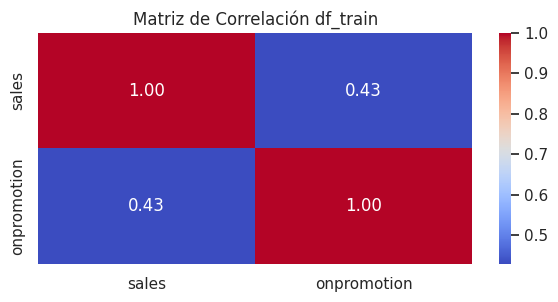

<ipython-input-16-9165077ca888>:8: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df_train.corr()


,sales,onpromotion
sales,1.000000,0.429947
onpromotion,0.429947,1.000000


In [ ]:
sns.set(style="white")
# Crear el mapa de calor de la matriz de correlación
plt.figure(figsize=(7, 3))
sns.heatmap(df_train.corr(), annot=True, cmap='coolwarm', fmt=".2f")
# Configurar el título
plt.title("Matriz de Correlación df_train")
plt.show()
df_train.corr()

Observamos una relación medianamente significativa entre ventas y "onpromotion" por lo que entrenar el modelo tomando en cuenta esa variable podría ser significativo sin embargo, decidimos no usarla para el modelo en esta ocasión.

<ipython-input-17-aa2a54c7c519>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  avg_sales = df_train.groupby('date').mean().sales


<Axes: xlabel='date'>

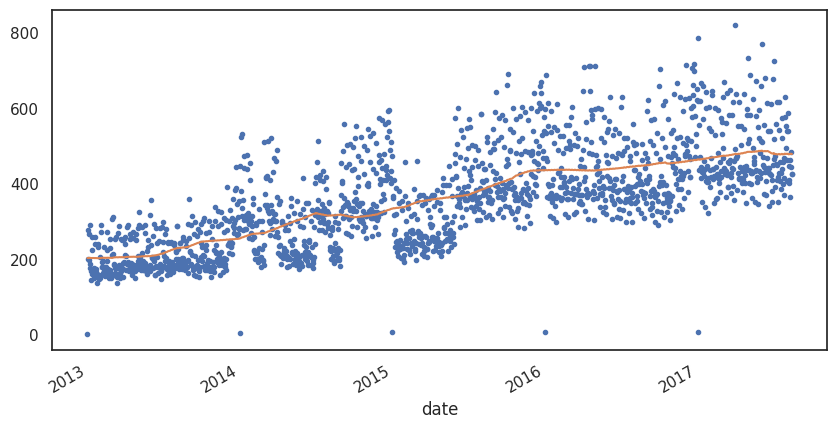

In [ ]:
avg_sales = df_train.groupby('date').mean().sales
avg_sales.plot(style='.', figsize=(10,5))
moving_avg = avg_sales.rolling(window=365, center=True, min_periods=183).mean()
moving_avg.plot()

La tendencia del promedio de ventas es positiva por lo que podemos concluir que la franquicia está creciendo a lo largo de los años. A su vez, aquellos puntos ubicados en el primer día anual de su respectivo año, tienen un total de 0 ventas, ya que, es un día festivo donde no se trabaja.

In [ ]:
df_train['date'] = df_train.date.dt.to_period('D')
df_train = df_train.set_index(['store_nbr', 'family', 'date']).sort_index()

Para el objetivo, se reducirá el periodo a uno diario, porque se busca analizar el efecto que tienen los días festivos en las ventas.

### Número de tiendas por ciudad

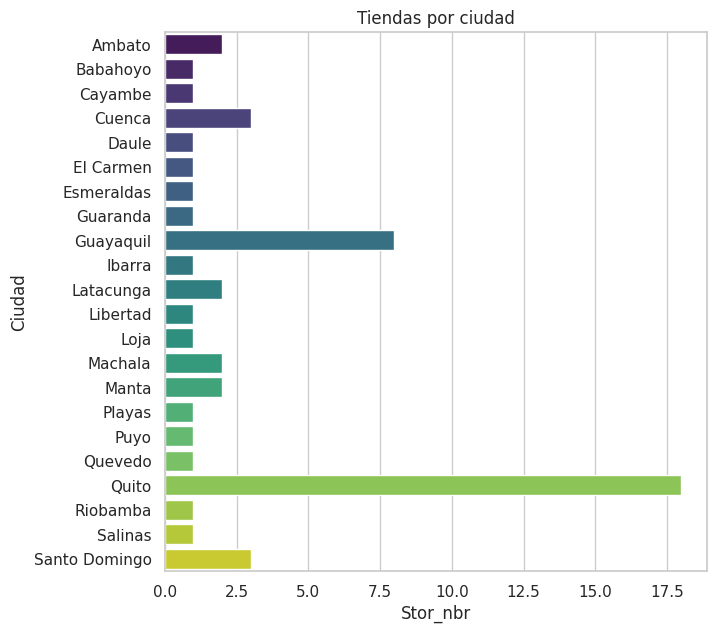

In [ ]:
sns.set(style='whitegrid')
group = df_stores.groupby('city')['store_nbr'].count().reset_index()
plt.figure(figsize=(7,7))
ax = sns.barplot(x='store_nbr', y='city', data=group, palette='viridis')
plt.xlabel("Stor_nbr")
plt.ylabel("Ciudad")
plt.title("Tiendas por ciudad")
plt.show()

In [ ]:
group.sort_values(by='store_nbr', ascending= False)

,city,store_nbr
18,Quito,18
8,Guayaquil,8
21,Santo Domingo,3
3,Cuenca,3
14,Manta,2
13,Machala,2
10,Latacunga,2
0,Ambato,2
7,Guaranda,1
9,Ibarra,1


Quito tiene el mayor número de tiendas por ser la capital de Ecuador, significando que es la mayor urbe del país.

### Tiendas con más transacciones

,store_nbr,transactions,city,state,type,cluster
0,44,7273093,Quito,Pichincha,A,5
1,47,6535810,Quito,Pichincha,A,14
2,45,6201115,Quito,Pichincha,A,11
3,46,5990113,Quito,Pichincha,A,14
4,3,5366350,Quito,Pichincha,D,8
5,48,5107785,Quito,Pichincha,A,14
6,8,4637971,Quito,Pichincha,D,8
7,49,4574103,Quito,Pichincha,A,11
8,50,4384444,Ambato,Tungurahua,A,14
9,11,3972488,Cayambe,Pichincha,B,6


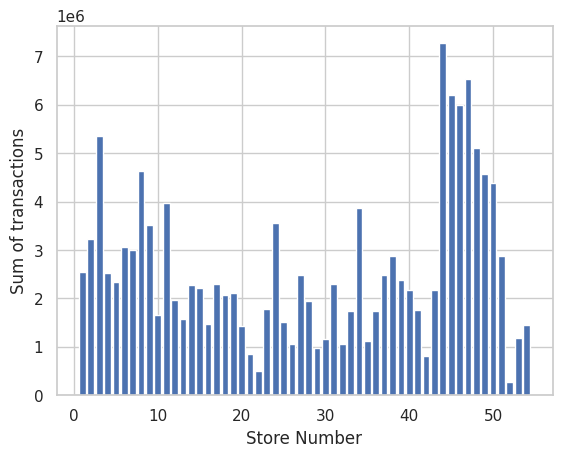

In [ ]:
group = df_transactions.groupby('store_nbr')['transactions'].sum().reset_index()
plt.bar(group['store_nbr'],group['transactions'])
plt.xlabel('Store Number')
plt.ylabel('Sum of transactions')
result = df_transactions.merge(df_stores, how='left')
result = result.groupby('store_nbr')['transactions'].sum().reset_index()
result = result.sort_values(by='transactions', ascending= False)
result = result.merge(df_stores, how='left')
result

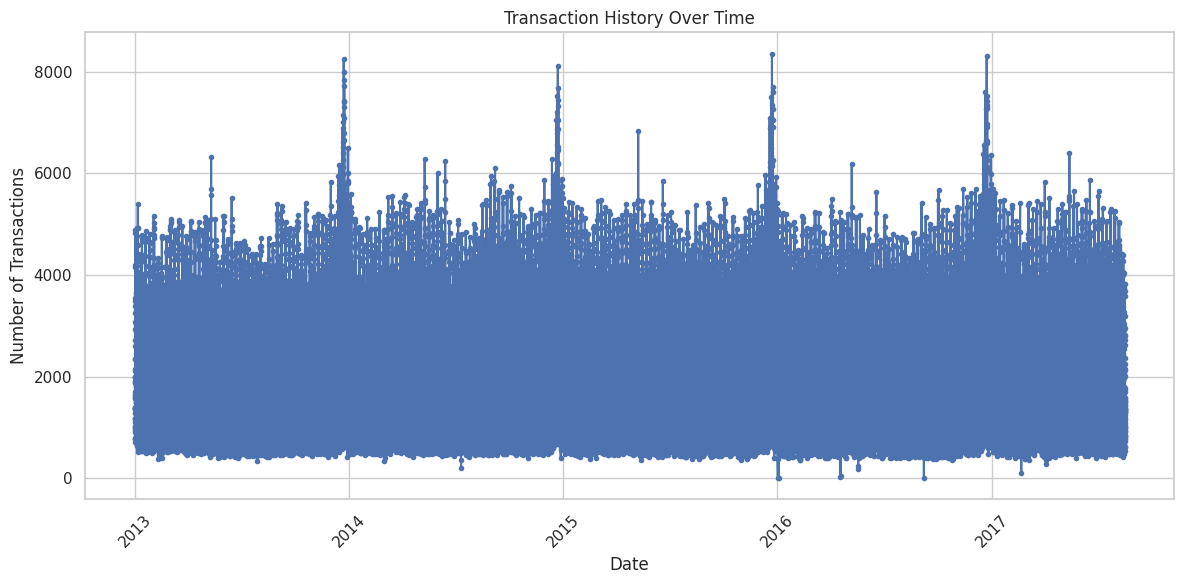

In [ ]:

plt.figure(figsize=(12, 6))
plt.plot(df_transactions['date'], df_transactions['transactions'], marker='.', linestyle='-')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Number of Transactions')
plt.title('Transaction History Over Time')

# Rotate x-axis labels for better readability (optional)
plt.xticks(rotation=45)

# Show the plot
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
dates_over_8000_transactions = df_transactions[df_transactions['transactions'] > 8000]

print("Dates with transactions over 8000:")
dates_over_8000_transactions['date']

Dates with transactions over 8000:


16570   2013-12-23
16572   2013-12-23
33700   2014-12-23
52011   2015-12-23
71010   2016-12-23
Name: date, dtype: datetime64[ns]

Se observa una clara tendencia a mayor número de transacciones a finales de año y hace sentido al ver las fechas con más de 8,000 transacciones, que son fechas justo antes de Navidad y en general, las festividades de fin de año.

### Valor del Oil por fecha

Text(0.5, 1.0, 'Precio del Oil a lo largo del Tiempo')

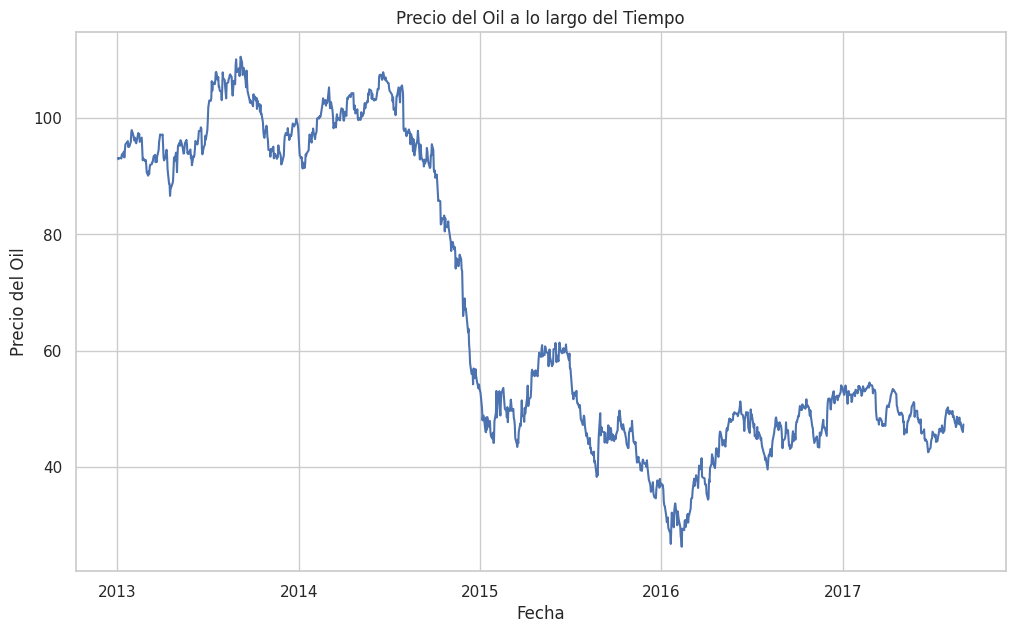

In [ ]:
sns.set(style='whitegrid')
plt.figure(figsize=(12,7))
sns.lineplot(x='date', y='dcoilwtico', data=df_oil)
plt.xlabel("Fecha")
plt.ylabel("Precio del Oil")
plt.title("Precio del Oil a lo largo del Tiempo")

Quitar los NaNs de Oil

In [ ]:
df_oil = df_oil.dropna()

En los datos del dataframe de oil se encontraron varios valores vacíos, se quitaron porque no afectan a la tendencia del precio del petróleo y no se ve una relación entre en precio y las ventas a lo largo de los años por lo que se decidió no usar los datos de esta tabla.

#Modelo de Predicción

El modelo de predicción a utilizar es un modelo de regresión lineal, debido a la facilidad de explicación que éste tiene para el público en general y a las propiedades de la situación. Además posee la ventaja de ser una línea base para comparar diferentes complejidades con otros modelos, para ser saber si realmente son necesarios para esta problemática.

In [ ]:
holidays = (
    df_holidays
    .query("locale in ['National', 'Regional']")
    .loc['2016-08-15':'2017-08-15', ['description']]
    .assign(description=lambda x: x.description.cat.remove_unused_categories())
)
holidays = holidays.drop(holidays[holidays['description'] == "Navidad"].index)

Los días festivos a analizar son específicamente a niveles regionales y nacionales, ya que a nivel local no tienen relevancia suficiente en las ventas.

In [ ]:
y = df_train.unstack(['store_nbr', 'family']).loc['2016-08-15':'2017-08-15']

fourier = CalendarFourier(freq="M", order=4)
dp = DeterministicProcess(
    index=y.index,
    constant=True,
    order=1,
    seasonal= True,
    additional_terms=[fourier],
    drop=True,
)
X = dp.in_sample()

Con el método de one-hot encoding, se cambian los valores categóricos de los días de la semana y los días festivos por valores numéricos. Esto con el objetivo de manejar esta información junto a las ventas en un mismo dataframe y poder utilizar esa información para la regresión.

In [ ]:
X_days = y.copy()
X_days = X_days.index.dayofweek
X_onehotdays = pd.get_dummies(X_days)

In [ ]:
X_onehotdays

,0,1,2,3,4,5,6
0,1,0,0,0,0,0,0
1,0,1,0,0,0,0,0
2,0,0,1,0,0,0,0
3,0,0,0,1,0,0,0
4,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...
360,0,0,0,0,1,0,0
361,0,0,0,0,0,1,0
362,0,0,0,0,0,0,1
363,1,0,0,0,0,0,0


In [ ]:
X_holidays = pd.get_dummies(holidays)

In [ ]:
X_holidays

,description_Batalla de Pichincha,description_Black Friday,description_Carnaval,description_Cyber Monday,description_Dia de Difuntos,description_Dia de la Madre,description_Dia de la Madre-1,description_Dia del Trabajo,description_Independencia de Cuenca,description_Independencia de Guayaquil,...,description_Provincializacion Santa Elena,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Provincializacion de Santo Domingo,description_Puente Dia de Difuntos,description_Recupero Puente Dia de Difuntos,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2016-10-09,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2016-11-02,0,0,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-11-03,0,0,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2016-11-04,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
2016-11-06,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
2016-11-07,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0
2016-11-12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2016-11-25,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2016-11-28,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [ ]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2016-08-15,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299363,-0.954139,-0.571268,0.820763,0.790776,-0.612106,-0.937752,0.347305
2016-08-16,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958
2016-08-17,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958
2016-08-18,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305
2016-08-19,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,0.897805,-0.440394
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,361.0,0.0,0.0,1.0,0.0,0.0,0.0,0.897805,-0.440394,-0.790776,-0.612106,-0.201299,0.979530,0.968077,-0.250653
2017-08-12,1.0,362.0,0.0,0.0,0.0,1.0,0.0,0.0,0.790776,-0.612106,-0.968077,-0.250653,0.394356,0.918958,0.485302,-0.874347
2017-08-13,1.0,363.0,0.0,0.0,0.0,0.0,1.0,0.0,0.651372,-0.758758,-0.988468,0.151428,0.848644,0.528964,-0.299363,-0.954139


In [ ]:
X.insert(0, 'reference', range(0, len(X)))

In [ ]:
X = X.merge(X_onehotdays, left_on='reference', right_on=X_onehotdays.index).set_index(X.index)

In [ ]:
X = X.drop('reference', axis=1)

In [ ]:
X = X.drop(0, axis=1)

In [ ]:
X

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",1,2,3,4,5,6
date,,,,,,,,,,,,,,,,,,,,,
2016-08-15,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299363,-0.954139,...,0.790776,-0.612106,-0.937752,0.347305,0,0,0,0,0,0
2016-08-16,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.101168,-0.994869,...,0.299363,-0.954139,-0.394356,0.918958,1,0,0,0,0,0
2016-08-17,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.101168,-0.994869,...,-0.299363,-0.954139,0.394356,0.918958,0,1,0,0,0,0
2016-08-18,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.299363,-0.954139,...,-0.790776,-0.612106,0.937752,0.347305,0,0,1,0,0,0
2016-08-19,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.485302,-0.874347,...,-0.998717,-0.050649,0.897805,-0.440394,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,361.0,0.0,0.0,1.0,0.0,0.0,0.0,0.897805,-0.440394,...,-0.201299,0.979530,0.968077,-0.250653,0,0,0,1,0,0
2017-08-12,1.0,362.0,0.0,0.0,0.0,1.0,0.0,0.0,0.790776,-0.612106,...,0.394356,0.918958,0.485302,-0.874347,0,0,0,0,1,0
2017-08-13,1.0,363.0,0.0,0.0,0.0,0.0,1.0,0.0,0.651372,-0.758758,...,0.848644,0.528964,-0.299363,-0.954139,0,0,0,0,0,1


In [ ]:
X2 = X.join(X_holidays, on='date').fillna(0.0)
X2

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Provincializacion Santa Elena,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Provincializacion de Santo Domingo,description_Puente Dia de Difuntos,description_Recupero Puente Dia de Difuntos,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2016-08-15,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.299363,-0.954139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-16,1.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.101168,-0.994869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-17,1.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.101168,-0.994869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-18,1.0,4.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.299363,-0.954139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2016-08-19,1.0,5.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.485302,-0.874347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017-08-11,1.0,361.0,0.0,0.0,1.0,0.0,0.0,0.0,0.897805,-0.440394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2017-08-12,1.0,362.0,0.0,0.0,0.0,1.0,0.0,0.0,0.790776,-0.612106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-13,1.0,363.0,0.0,0.0,0.0,0.0,1.0,0.0,0.651372,-0.758758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Para el correcto funcionamiento del dataframe y la facilidad de entendimiento de éste, se renombran aquellas columnas que representaban los días de la semana.

In [ ]:
X2 = X2.rename(columns={1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

Se aplica la regresión lineal y se entrenan los datos.

In [ ]:
model = LinearRegression()
model.fit(X2, y)
y_pred = pd.DataFrame(
    model.predict(X2),
    index=X2.index,
    columns=y.columns
    )

Se toma una muestra de 16 "steps" adelante del proceso determinístico que para nuestro caso, son días. Entonces nuestra predicción será para los 16 días siguientes a los que se acaba nuestra data de entrenamiento.

In [ ]:
X_test = dp.out_of_sample(steps=16)
X_test.index.name = 'date'

In [ ]:
X_test

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)","sin(2,freq=M)","cos(2,freq=M)","sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)"
date,,,,,,,,,,,,,,,,
2017-08-16,1.0,366.0,1.0,0.0,0.0,0.0,0.0,0.0,0.101168,-0.994869,-0.201299,0.979530,0.299363,-0.954139,-0.394356,0.918958
2017-08-17,1.0,367.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.101168,-0.994869,0.201299,0.979530,-0.299363,-0.954139,0.394356,0.918958
2017-08-18,1.0,368.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.299363,-0.954139,0.571268,0.820763,-0.790776,-0.612106,0.937752,0.347305
2017-08-19,1.0,369.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.485302,-0.874347,0.848644,0.528964,-0.998717,-0.050649,0.897805,-0.440394
2017-08-20,1.0,370.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.651372,-0.758758,0.988468,0.151428,-0.848644,0.528964,0.299363,-0.954139
2017-08-21,1.0,371.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.790776,-0.612106,0.968077,-0.250653,-0.394356,0.918958,-0.485302,-0.874347
2017-08-22,1.0,372.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.897805,-0.440394,0.790776,-0.612106,0.201299,0.979530,-0.968077,-0.250653
2017-08-23,1.0,373.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.968077,-0.250653,0.485302,-0.874347,0.724793,0.688967,-0.848644,0.528964
2017-08-24,1.0,374.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.998717,-0.050649,0.101168,-0.994869,0.988468,0.151428,-0.201299,0.979530


Se somete la data de prueba al mismo proceso que se sometió la data de entrenamiento para que la predicción sea de la misma calidad.

In [ ]:
X_days = X_test.index.dayofweek
X_onehotdays = pd.get_dummies(X_days)

X_holidays = pd.get_dummies(holidays)

In [ ]:
X_test.insert(0, 'reference', range(0, len(X_test)))

X_test = X_test.merge(X_onehotdays, left_on='reference', right_on=X_onehotdays.index).set_index(X_test.index)

X_test = X_test.drop('reference', axis=1)

X_test = X_test.drop(0, axis=1)

In [ ]:
X_test

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,"sin(3,freq=M)","cos(3,freq=M)","sin(4,freq=M)","cos(4,freq=M)",1,2,3,4,5,6
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,366.0,1.0,0.0,0.0,0.0,0.0,0.0,0.101168,-0.994869,...,0.299363,-0.954139,-0.394356,0.918958,0,1,0,0,0,0
2017-08-17,1.0,367.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.101168,-0.994869,...,-0.299363,-0.954139,0.394356,0.918958,0,0,1,0,0,0
2017-08-18,1.0,368.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.299363,-0.954139,...,-0.790776,-0.612106,0.937752,0.347305,0,0,0,1,0,0
2017-08-19,1.0,369.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.485302,-0.874347,...,-0.998717,-0.050649,0.897805,-0.440394,0,0,0,0,1,0
2017-08-20,1.0,370.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.651372,-0.758758,...,-0.848644,0.528964,0.299363,-0.954139,0,0,0,0,0,1
2017-08-21,1.0,371.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.790776,-0.612106,...,-0.394356,0.918958,-0.485302,-0.874347,0,0,0,0,0,0
2017-08-22,1.0,372.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.897805,-0.440394,...,0.201299,0.979530,-0.968077,-0.250653,1,0,0,0,0,0
2017-08-23,1.0,373.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.968077,-0.250653,...,0.724793,0.688967,-0.848644,0.528964,0,1,0,0,0,0
2017-08-24,1.0,374.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.998717,-0.050649,...,0.988468,0.151428,-0.201299,0.979530,0,0,1,0,0,0


In [ ]:
X_test = X_test.join(X_holidays, on='date').fillna(0.0)
X_test = X_test.rename(columns={1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

In [ ]:
X_test

,const,trend,"s(2,7)","s(3,7)","s(4,7)","s(5,7)","s(6,7)","s(7,7)","sin(1,freq=M)","cos(1,freq=M)",...,description_Provincializacion Santa Elena,description_Provincializacion de Cotopaxi,description_Provincializacion de Imbabura,description_Provincializacion de Santo Domingo,description_Puente Dia de Difuntos,description_Recupero Puente Dia de Difuntos,description_Traslado Batalla de Pichincha,description_Traslado Primer Grito de Independencia,description_Traslado Primer dia del ano,description_Viernes Santo
date,,,,,,,,,,,,,,,,,,,,,
2017-08-16,1.0,366.0,1.0,0.0,0.0,0.0,0.0,0.0,0.101168,-0.994869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-17,1.0,367.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.101168,-0.994869,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-18,1.0,368.0,0.0,0.0,1.0,0.0,0.0,0.0,-0.299363,-0.954139,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-19,1.0,369.0,0.0,0.0,0.0,1.0,0.0,0.0,-0.485302,-0.874347,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-20,1.0,370.0,0.0,0.0,0.0,0.0,1.0,0.0,-0.651372,-0.758758,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-21,1.0,371.0,0.0,0.0,0.0,0.0,0.0,1.0,-0.790776,-0.612106,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-22,1.0,372.0,0.0,0.0,0.0,0.0,0.0,0.0,-0.897805,-0.440394,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-23,1.0,373.0,1.0,0.0,0.0,0.0,0.0,0.0,-0.968077,-0.250653,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2017-08-24,1.0,374.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.998717,-0.050649,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Se da al dataframe el formato específico definido por Kaggle para la evaluación del resultado. Y en caso de que se esté subiendo el resultado a la competencia, se descomenta la línea que genera el archivo de salida con el formato adecuado.

In [ ]:
y_submit = pd.DataFrame(model.predict(X_test), index=X_test.index, columns=y.columns)
y_submit = y_submit.stack(['store_nbr', 'family'])
y_submit = y_submit.join(df_test.id).reindex(columns=['id', 'sales'])
y_submit
# y_submit.to_csv('submission.csv', index=False)

id        sales
date       store_nbr family                                          
2017-08-16 1         AUTOMOTIVE                  3000888     4.245668
                     BABY CARE                   3000889     0.000000
                     BEAUTY                      3000890     3.379239
                     BEVERAGES                   3000891  2513.521022
                     BOOKS                       3000892     0.855768
...                                                  ...          ...
2017-08-31 9         POULTRY                     3029395   349.728227
                     PREPARED FOODS              3029396   112.456899
                     PRODUCE                     3029397  1369.614736
                     SCHOOL AND OFFICE SUPPLIES  3029398    10.679607
                     SEAFOOD                     3029399    14.397689

[28512 rows x 2 columns]

In [ ]:
y_frame = y_submit.copy()

Se grafican los resultados de las predicciones, teniendo como ejemplo de la capacidad del modelo entrenado, las ventas por el número de tienda 1, de la familia "produce".

In [ ]:
STORE_NBR = '1'
FAMILY = 'PRODUCE'

<Axes: title={'center': 'Ventas de la tienda 1 de la familia PRODUCE'}, xlabel='date'>

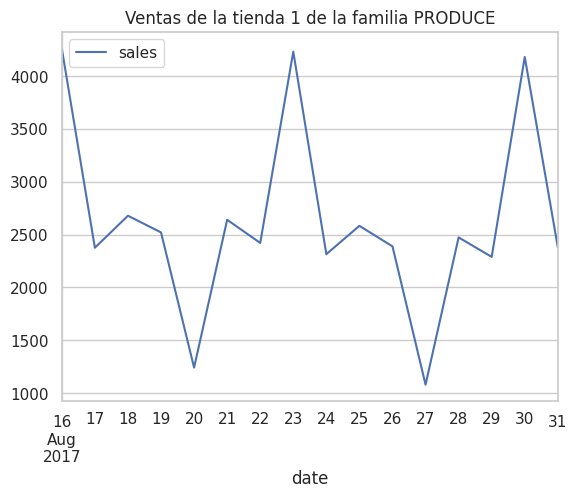

In [ ]:
y_frame = y_frame[(y_frame.index.get_level_values('store_nbr') == '1') & (y_frame.index.get_level_values('family') == 'PRODUCE')]
y_frame.reset_index().plot(x= 'date', y= 'sales', title= (f'Ventas de la tienda {STORE_NBR} de la familia {FAMILY}'))